<a href="https://colab.research.google.com/github/Ankur-singh/CrowdSource-Workshop/blob/main/00_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Image classifier using `fastai`
---

### What is Google Colab and Fastai?

#### **Google Colab**
- Jupyter notebooks hosted by google
- Executes Python code (and bash commands)
- Supports markdown (TEXT)
- Interactivity
- To run a cell press `shift+enter`

**Note:** You can watch [this video](https://www.youtube.com/watch?v=HW29067qVWk) if you are hearing jupyter notebook for the first time.




#### **Fastai**
- It is a deep learning library written in python
- It provides high-level components that can quickly and easily provide *state-of-the-art* results in standard deep learning domains.
- Key features: **ease of use**, **flexibility**, and **performance**.
- Visit [fastai docs](https://docs.fast.ai/) to learn more.

#### **Use GPU** 
Make sure you are using a **GPU** runtime. Click on `runtime` -> `change runtime type`. Under hardware accelerator select **GPU** and click **SAVE**.



#### **Setup**

Fastai comes pre-installed in google colab but its an older version. So, we will first update `fastai` 

In [ ]:
!pip install -U -q fastai

     |████████████████████████████████| 194kB 6.4MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 


In [ ]:
from fastai.vision.all import *

**Note**: Make sure you are using a **GPU** runtime.

## Image Classifier

For building an image classifier, we will need 3 things:
- Data (images and labels)
- Data Loaders
- Learner

Lets start by collecting data:

### Collecting data

Lets start by creating a `data` folder where we will keep all our data.

In [ ]:
path = Path('data')
path.mkdir(parents=True, exist_ok=True)

For building an image classifier we will need urls of images. Generally, you need 80-150 images per class to train a good model.

There are 3 possible ways of collecting data:
- Manually copy pasting image urls - Not recommended.
- Use existing [datasets](https://github.com/Ankur-singh/image_scrapper/tree/master/datasets).
- Use [Image_url_scaper](https://share.streamlit.io/ankur-singh/image_scrapper).

In [ ]:
!wget -q https://raw.githubusercontent.com/Ankur-singh/image_scrapper/master/datasets/bear.txt
!wget -q https://raw.githubusercontent.com/Ankur-singh/image_scrapper/master/datasets/horse.txt
!wget -q https://raw.githubusercontent.com/Ankur-singh/image_scrapper/master/datasets/dog.txt

Once we have all the URLs, we can easily download them using `download_images` function. 


In [ ]:
download_images('data/horse', Path('horse.txt'))
download_images('data/dog', Path('dog.txt'))
download_images('data/bear', Path('bear.txt'))

In [ ]:
files = get_image_files(path)
len(files)

521

In [ ]:
failed = verify_images(files)
failed

(#5) [Path('data/bear/00000167.jpg'),Path('data/bear/00000087.jpg'),Path('data/horse/00000085.svg'),Path('data/horse/00000174.jpg'),Path('data/dog/00000081.jpg')]

In [ ]:
failed.map(Path.unlink) # delete corrupted files

(#5) [None,None,None,None,None]

In [ ]:
files = get_image_files(path)
len(files)

526

Jupyter notebooks make it so easy to gradually build what you want, and check your work every step of the way. I, personally, make a lot of mistakes, so this is really helpful to me...

Jupyter notebooks are great for experimenting and immediately seeing the results of each function, but there is also a lot of functionality to help you figure out how to use different functions, or even directly look at their source code. For instance, if you type in a cell:

In [ ]:
verify_images??

This tells us what argument the function accepts (files), then shows us the source code and the file it comes from. Looking at that source code, we can see it applies the function `verify_image` in parallel and only keeps the image files for which the result of that function is `False`, which is consistent with the doc string: it finds the images in *files* that can't be opened.


### DataLoaders

In machine learning, almost all algorithms take the complete dataset while training. But in-case of deep learning, you don't pass the complete data at once.

You divide the data into smaller batches and pass the batches as input to deep learnining model. **DataLoaders** allows us to train models on huge dataset. It parallely load the data, in batches, while the model is training.

But we don't have to worry about it. The `Datablocks` API will take care of everything for us.

To turn our downloaded data into a DataLoaders object we need to tell fastai at least four things:

1. What kinds of data we are working with
1. How to get the list of items
1. How to label these items
1. How to create the validation set

This is how we can create a `DataLoaders` for the dataset that we just downloaded:

In [ ]:
animals = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # x,y
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())

Let's look at each of these arguments in turn. First we provide a tuple where we specify what types we want for the **independent** and **dependent** variables:

```python
blocks=(ImageBlock, CategoryBlock)
```
The independent variable is the thing we are using to make predictions from, and the dependent variable is our target. In this case, our independent variables are **images**, and our dependent variables are the **categories** (type of animal) for each image. 

For this DataLoaders our underlying items will be file paths. We have to tell fastai how to get a list of those files. The `get_image_files` function takes a path, and returns a list of all of the images in that path (recursively, by default):

```python
get_items=get_image_files
```

Next, we will randomly split our data into **training** and **validation** sets. However, we would like to have the same training/validation split each time we run this notebook, so we fix the *random seed* (computers don't really know how to create random numbers at all, but simply create lists of numbers that look random; if you provide the same starting point for that list each time—called the seed—then you will get the exact same list each time):

```python
splitter=RandomSplitter(valid_pct=0.2, seed=42)
```
The independent variable is often referred to as `x` and the dependent variable is often referred to as `y`. Here, we are telling fastai what function to call to create the labels in our dataset:

```python
get_y=parent_label
```
`parent_label` function simply gets the name of the folder a file is in. Because we put each of our images into folders based on its class, this is going to give us the labels that we need.

Our images are all different sizes, and this is a problem for deep learning: we don't feed the model one image at a time but several of them (what we call a mini-batch). To group them in a big array (usually called a tensor) that is going to go through our model, they all need to be of the same size. So, we need to add a transform which will resize these images to the same size. Item transforms are pieces of code that run on each individual item, whether it be an image, category, or so forth. Here, we'll use `RandomResizedCrop` with an image size of 224 px, which is fairly standard for image classification, and default `aug_transforms`:

```python
item_tfms=RandomResizedCrop(224, min_scale=0.5),
batch_tfms=aug_transforms()
```

This command has given us a DataBlock object. This is like a template for creating a DataLoaders. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found:

In [ ]:
dls = animals.dataloaders(path)

A DataLoaders includes validation and training DataLoaders. DataLoader is a class that provides batches of a few items at a time to the GPU. 

When you loop through a DataLoader, by default you will get 64 items per batch, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a DataLoader:

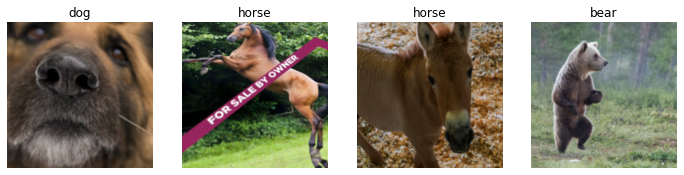

In [ ]:
dls.train.show_batch(max_n=4, nrows=1)

### Learner

Fastai's `learner` class, put together everything. 
- DataLoaders
- Model Architecture
- Loss function and metric
- Training loop, callbacks and much more. 

Then we can create a `Learner`, which is a fastai object that combines the data and a model for training, and uses transfer learning to fine tune a pretrained model in just two lines of code:

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.388749,0.125575,0.048077,00:26


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch,train_loss,valid_loss,error_rate,time
0,0.216419,0.104376,0.028846,00:25
1,0.189550,0.103386,0.028846,00:26
2,0.144239,0.118304,0.038462,00:26


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


The first line downloaded a model called `ResNet18`, pretrained on ImageNet, and adapted it to our specific problem. It then fine tuned that model and in a relatively short time, we get a model with very high accuracy... amazing!

If you want to make a prediction on a new image, you can use `learn.predict`:

In [ ]:
files[10]

Path('data/bear/00000048.jpg')

In [ ]:
learn.predict(files[10])

('bear', tensor(0), tensor([9.9998e-01, 6.1400e-06, 1.3789e-05]))

The predict method returns three things: 
1. the decoded prediction, 
2. the index of the predicted class and 
3. the tensor of probabilities of all classes in the order of their indexed labels. 

`predict` method accepts a filename, a PIL image or a tensor directly in this case. We can also have a look at multiple predictions at once, with the `learn.show_results` method:

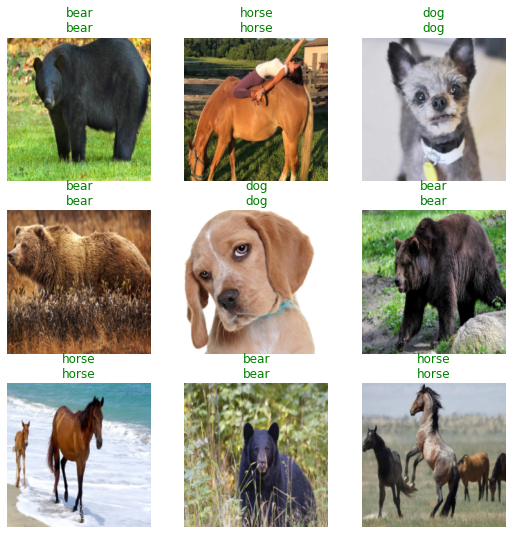

In [ ]:
learn.show_results()

It might look like a lot of code. But actually not. Lets try to re-create everything that we learned above 

In [ ]:
## Getting Data


In [ ]:
## DataLoaders


In [ ]:
## Learner


In [ ]:
## Making predictions


## Inference

Now let's see whether the mistakes the model is making. To visualize it, we can create a confusion matrix:

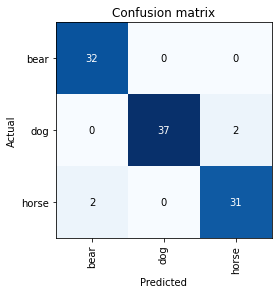

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The rows represents the actual classes. The columns represent the classes predicted by our model. Therefore, the diagonal of the matrix shows the images which were classified correctly, and the off-diagonal cells represent those which were classified incorrectly. The color-coding, makes it super easy to visualize mistakes. Our image classifier isn't making many mistakes!

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their loss.

The loss is a number that is higher if the model is incorrect (especially if it's also confident of its incorrect answer), or if it's correct, but not confident of its correct answer. `plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The probability here is the confidence level, from zero to one, that the model has assigned to its prediction:

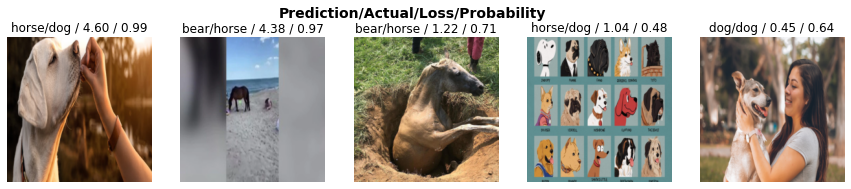

In [ ]:
interp.plot_top_losses(5, nrows=1)

We can see the some very different images.

The intuitive approach to doing data cleaning is to do it before you train a model. But as you've seen in this case, a model can actually help you find data issues more quickly and easily. So, you can normally prefer to train a quick and simple model first, and then use it to help us with data cleaning.

### Use-cases

- **Devanagari (देवनागरी) characters** : https://forums.fast.ai/t/share-your-work-here/27676/38
- Distracted Driver: https://www.kaggle.com/c/state-farm-distracted-driver-detection/data
- **DeepFashion**: https://medium.com/@pankajmathur/clothing-categories-classification-using-fast-ai-v1-0-in-10-lines-of-code-4e848797721
- hotel & hostel rooms
- Messi Classifier
- Currency classifier
- X-ray classifier and
- much more.

### Things to google
- DataLoaders
- Convolutional Neural Networks (CNNs)
- ImageNet Competition
- Transfer Learning
- Confusion Matrix

### Exercise
Try building your own classifier.